# Data prep

In [1]:
import pandas as pd

from sklearn.preprocessing import RobustScaler

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [2]:
expired = pd.read_csv("../data/expired_data.csv").iloc[:, 1:]
death_target = expired.iloc[:, -1]
death_data = expired.iloc[:, :-1]

expired_scaler = RobustScaler()

death_data = expired_scaler.fit_transform(death_data)

In [3]:
icu = pd.read_csv("../data/icu_data.csv").iloc[:, 1:]
icu_target = icu.iloc[:, -1]
icu_data = icu.iloc[:, :-1]

icu_scaler = RobustScaler()

icu_data = icu_scaler.fit_transform(icu_data)

In [4]:
def split_and_pack(X, y, name=None):
  from sklearn.model_selection import train_test_split

  sets = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=13123)
  return {
      "name": name,
      "X_train": sets[0],
      "X_test": sets[1],
      "y_train": sets[2],
      "y_test": sets[3]
  }

ICU_PACK = split_and_pack(icu_data, icu_target)
EXPIRED_PACK = split_and_pack(death_data, death_target)

In [5]:
def plot_feature_importance(model, data, colnames):
    
    e = shap.DeepExplainer(model, data)
    sh = e.shap_values(data)
    shap.summary_plot(sh, features=data, feature_names=colnames, plot_type='bar')

In [6]:
expired.iloc[:, :-1].columns

Index(['Age', 'CRP', 'LDH', 'SpO2', 'Procalcitonin', 'Troponin'], dtype='object')

In [7]:
icu.iloc[:, :-1].columns

Index(['CRP', 'Ferritin', 'LDH', 'SpO2', 'Procalcitonin'], dtype='object')

# ICU Models 

In [8]:
def make_article_layer(neurons, **kwargs):
  return Dense(neurons, activation="relu", kernel_initializer="he_normal", kernel_regularizer="l2", **kwargs)

def make_article_model(loss="mean_squared_error", input_shape=(5,)):
  # The DNN model used five hidden layers with 6, 8, 16, 8, 4 neurons respectively.
  model = Sequential()
  model.add(make_article_layer(6, input_shape=input_shape))
  model.add(make_article_layer(8))
  model.add(make_article_layer(16))
  model.add(make_article_layer(8))
  model.add(make_article_layer(4))
  # [...] the sigmoid activation function for the output layer, and the “he_normal” normalization scheme were applied. 
  model.add(Dense(1, activation="sigmoid", kernel_initializer="he_normal", kernel_regularizer="l2"))
  model.compile(optimizer="adam", loss=loss, metrics=["accuracy"])
  return model

In [9]:
icu_article = make_article_model()
icu_article.fit(ICU_PACK["X_train"], ICU_PACK["y_train"], epochs=100, validation_split=0.2, verbose=0)
roc_auc_score(ICU_PACK["y_test"], icu_article.predict(ICU_PACK["X_test"])[:, 0])

0.5694444444444445

In [31]:
icu_article.save("icu_article.h5")

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


<Figure size 560x350 with 0 Axes>

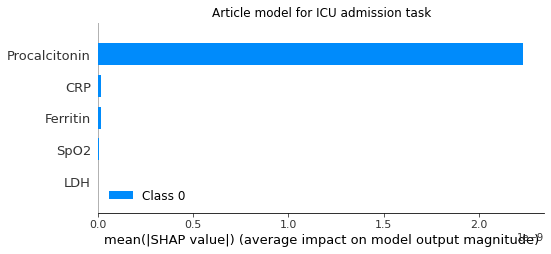

In [51]:
plt.figure(figsize=(8,5), dpi= 70)
fig, ax = plt.subplots()
plt.title("Article model for ICU admission task")
ax=plot_feature_importance(icu_article, ICU_PACK["X_train"], icu.iloc[:, :-1].columns)
plt.show()
fig.savefig('article_icu_feature.png')

In [11]:
icu.iloc[:, :-1].columns

Index(['CRP', 'Ferritin', 'LDH', 'SpO2', 'Procalcitonin'], dtype='object')

In [12]:
def plot_roc_keras(model, PACK, model_name="?"):
  from sklearn.metrics import roc_curve, RocCurveDisplay
  
  y_pred_keras = model.predict(PACK["X_test"]).ravel()
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(PACK["y_test"], y_pred_keras)
  plt.plot(fpr_keras, tpr_keras)
  plt.plot([0,1], [0,1], "r--")
  plt.xlabel("FPR")
  plt.ylabel("TPR")
  plt.title("ROC Curve for " + model_name)

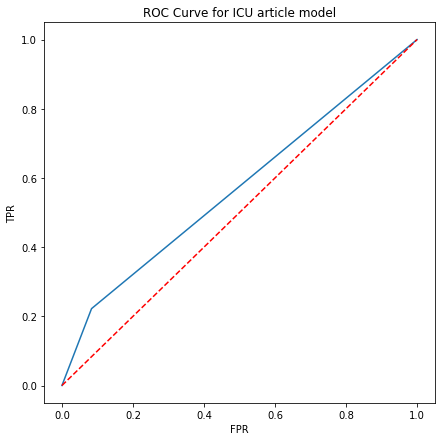

In [13]:
plt.figure(figsize=(7, 7))
plot_roc_keras(icu_article, ICU_PACK, model_name="ICU article model")

In [14]:
def test_stability(model_constructor, pack, count=25, verbose=False, scorer=roc_auc_score, save_name=None):
  aucs = []

  for i in range(1, count + 1):
    if verbose:
      print(f"Training model #{i}")

    m = model_constructor()
    m.fit(pack["X_train"], pack["y_train"], epochs=100, validation_split=0.2, verbose=0)
    roc = roc_auc_score(pack["y_test"], m.predict(pack["X_test"])[:, 0])
    if verbose:
      print(f"ROC AUC: {roc}")
    if save_name is not None:
        m.save(f"saved_models/{save_name}_{i}.h5")
    aucs.append(roc)
  return aucs

In [15]:
ICU_ROCS = test_stability(make_article_model, ICU_PACK, count=5, verbose=True)

Training model #1
ROC AUC: 0.7182539682539683
Training model #2
ROC AUC: 0.5
Training model #3
ROC AUC: 0.7208994708994708
Training model #4
ROC AUC: 0.7197971781305114
Training model #5
ROC AUC: 0.7173721340388007


In [18]:
ARTICLE_ICU_AUCS_25 = test_stability(make_article_model, ICU_PACK, save_name="article_icu")

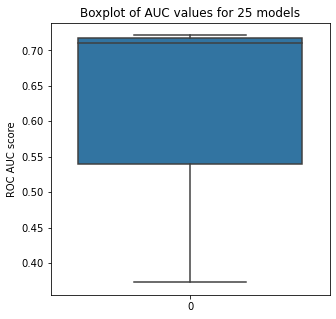

In [17]:
plt.figure(figsize=(5,5))
sns.boxplot(data=ARTICLE_ICU_AUCS_25)
plt.ylabel("ROC AUC score")
plt.title("Boxplot of AUC values for 25 models")
plt.show()

# Modified ICU models

In [19]:
def make_wider(input_shape=(5,)):
  wider = Sequential()
  wider.add(Dense(32, activation="relu", input_shape=input_shape))
  wider.add(Dense(32, activation="relu"))
  wider.add(Dense(1, activation="sigmoid"))
  wider.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
  return wider

In [20]:
oicu = make_wider()
oicu.fit(ICU_PACK["X_train"], ICU_PACK["y_train"], epochs=100, validation_split=0.2, verbose=0)
roc_auc_score(ICU_PACK["y_test"], oicu.predict(ICU_PACK["X_test"])[:, 0])

0.7314814814814815

In [13]:
oicu.save("icu_basic.h5")

<Figure size 560x350 with 0 Axes>

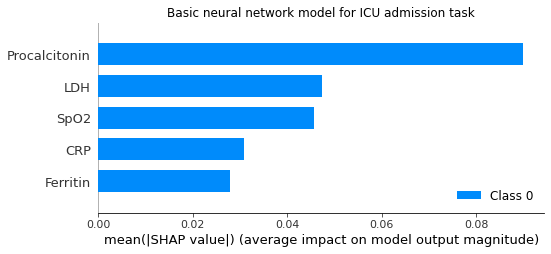

In [52]:
plt.figure(figsize=(8,5), dpi= 70)
fig, ax = plt.subplots()
plt.title("Basic neural network model for ICU admission task")
ax = plot_feature_importance(oicu, ICU_PACK["X_train"], icu.iloc[:, :-1].columns)
plt.show()
fig.savefig('basic_icu_feature.png') #, bbox_inches='tight' <- eliminuje to białe obramowanie

In [23]:
article_ce_model = make_article_model(loss="binary_crossentropy")
article_ce_model.fit(ICU_PACK["X_train"], ICU_PACK["y_train"], epochs=100, validation_split=0.2, verbose=0)
roc_auc_score(ICU_PACK["y_test"], article_ce_model.predict(ICU_PACK["X_test"])[:, 0])

0.6556437389770723

In [15]:
article_ce_model.save("icu_article_ce.h5")

<Figure size 560x350 with 0 Axes>

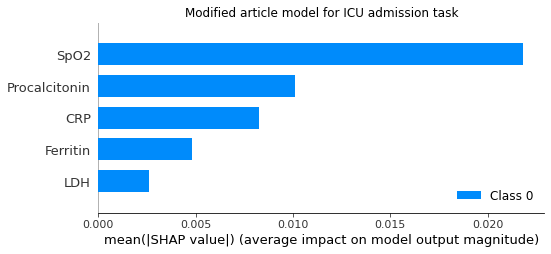

In [53]:
plt.figure(figsize=(8,5), dpi= 70)
fig, ax = plt.subplots()
plt.title("Modified article model for ICU admission task")
ax = plot_feature_importance(article_ce_model, ICU_PACK["X_train"], icu.iloc[:, :-1].columns)
plt.show()
fig.savefig('modified_icu_feature.png')

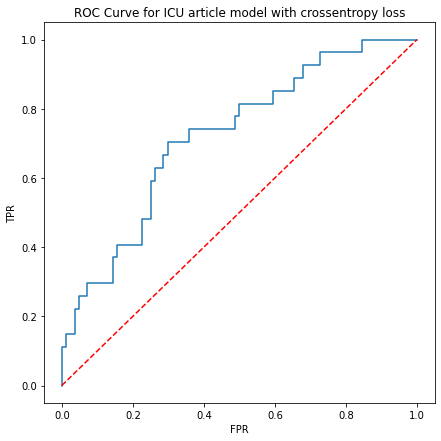

In [ ]:
plt.figure(figsize=(7,7))
plot_roc_keras(article_ce_model, ICU_PACK, model_name="ICU article model with crossentropy loss")

In [31]:
NEW_ICU_AUCS = test_stability(make_wider, ICU_PACK, save_name="basic_icu")

In [32]:
ARTICLE_BCE_ICU_AUCS = test_stability(lambda: make_article_model(loss="binary_crossentropy"), ICU_PACK, save_name="modded_icu")

In [33]:
plot_df = pd.DataFrame({
    "article": ARTICLE_ICU_AUCS_25,
    "basic": NEW_ICU_AUCS,
    "article (crossentropy)" : ARTICLE_BCE_ICU_AUCS
})

In [ ]:
plot_df.to_csv("icu_stability.csv", index=False)

<Figure size 560x350 with 0 Axes>

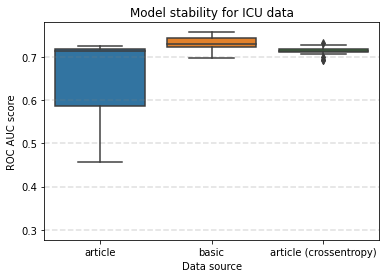

In [54]:
plt.figure(figsize=(8,5), dpi= 70)
fig,ax=plt.subplots()
ax=sns.boxplot(data=plot_df.melt(var_name="type", value_name="ROC AUC score"), x="type", y="ROC AUC score")
for i in range(3, 8):
  plt.hlines(i*0.1, -0.5, 2.5, colors='gray', linestyles= 'dashed', alpha=0.25)
plt.xlabel("Data source")
plt.title("Model stability for ICU data")
plt.show()
fig.savefig('5-4-icu_nn.png')

# Predicting death

In [36]:
article_d_model = make_article_model(input_shape=(6,))
article_d_model.fit(EXPIRED_PACK["X_train"], EXPIRED_PACK["y_train"], epochs=100, validation_split=0.2, verbose=0)
roc_auc_score(EXPIRED_PACK["y_test"], article_d_model.predict(EXPIRED_PACK["X_test"])[:, 0])

0.8451548451548452

In [17]:
article_d_model.save("death_article.h5")

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


<Figure size 560x350 with 0 Axes>

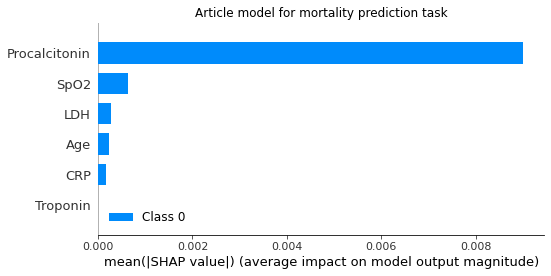

In [55]:
plt.figure(figsize=(8,5), dpi= 70)
fig, ax = plt.subplots()
plt.title("Article model for mortality prediction task")
ax=plot_feature_importance(article_d_model, EXPIRED_PACK["X_train"], expired.iloc[:, :-1].columns)
plt.show()
fig.savefig('article_mortality_feature.png')

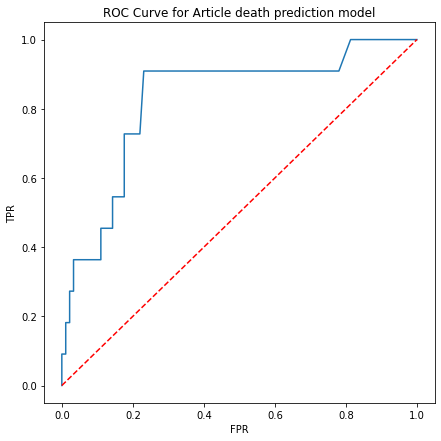

In [ ]:
plt.figure(figsize=(7,7))
plot_roc_keras(article_d_model, EXPIRED_PACK, model_name="Article death prediction model")

In [38]:
basic_d = make_wider(input_shape=(6,))
basic_d.fit(EXPIRED_PACK["X_train"], EXPIRED_PACK["y_train"], epochs=100, validation_split=0.2, verbose=0)
#basic_d.save("death_basic.h5")
roc_auc_score(EXPIRED_PACK["y_test"], basic_d.predict(EXPIRED_PACK["X_test"])[:, 0])

0.8621378621378621

In [39]:
modded_d = make_article_model(loss="binary_crossentropy", input_shape=(6,))
modded_d.fit(EXPIRED_PACK["X_train"], EXPIRED_PACK["y_train"], epochs=100, validation_split=0.2, verbose=0)
#modded_d.save("death_article_ce.h5")
roc_auc_score(EXPIRED_PACK["y_test"], modded_d.predict(EXPIRED_PACK["X_test"])[:, 0])

0.8736263736263736

In [40]:
ARTICLE_EXPIRED_AUCS = test_stability(lambda: make_article_model(input_shape=(6,)), EXPIRED_PACK)

In [41]:
BASIC_EXPIRED_AUCS = test_stability(lambda: make_wider(input_shape=(6,)), EXPIRED_PACK)

In [42]:
ARTICLE_BCE_EXPIRED_AUCS = test_stability(lambda: make_article_model(loss="binary_crossentropy", input_shape=(6,)), EXPIRED_PACK)

In [43]:
plot_exp_df = pd.DataFrame({
    "article": ARTICLE_EXPIRED_AUCS,
    "basic": BASIC_EXPIRED_AUCS,
    "article (crossentropy)" : ARTICLE_BCE_EXPIRED_AUCS
})

In [ ]:
plot_exp_df.to_csv("expired_stability.csv", index=False)

<Figure size 560x350 with 0 Axes>

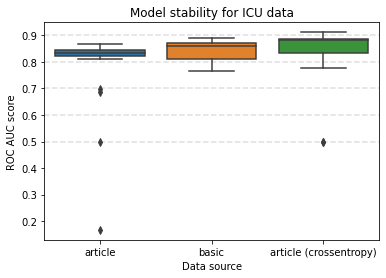

In [56]:
plt.figure(figsize=(8,5), dpi= 70)
fig,ax=plt.subplots()
ax = sns.boxplot(data=plot_exp_df.melt(var_name="type", value_name="ROC AUC score"), x="type", y="ROC AUC score")
for i in range(5, 10):
  plt.hlines(i*0.1, -0.5, 2.5, colors='gray', linestyles= 'dashed', alpha=0.25)
plt.xlabel("Data source")
plt.title("Model stability for ICU data")
plt.show()
fig.savefig('5-4-mortality_nn.png')

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


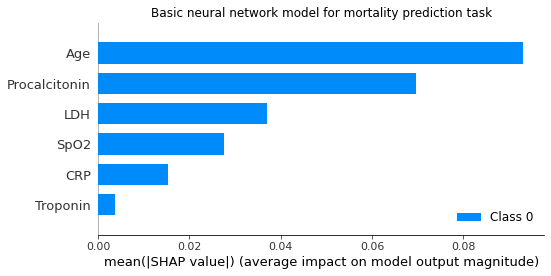

In [57]:
article_d_model_wider = make_wider(input_shape=(6,))
article_d_model_wider.fit(EXPIRED_PACK["X_train"], EXPIRED_PACK["y_train"], epochs=100, validation_split=0.2, verbose=0)
fig, ax = plt.subplots()
plt.title("Basic neural network model for mortality prediction task")
plot_feature_importance(article_d_model_wider, EXPIRED_PACK["X_train"], expired.iloc[:, :-1].columns)
plt.show()
fig.savefig('basic_mortality_feature.png')

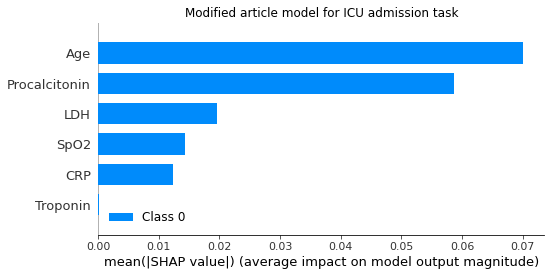

In [58]:
fig, ax = plt.subplots()
plt.title("Modified article model for ICU admission task")
article_d_model_crossentropy = make_article_model(loss="binary_crossentropy", input_shape=(6,))
article_d_model_crossentropy.fit(EXPIRED_PACK["X_train"], EXPIRED_PACK["y_train"], epochs=100, validation_split=0.2, verbose=0)
ax=plot_feature_importance(article_d_model_crossentropy, EXPIRED_PACK["X_train"], expired.iloc[:, :-1].columns)
plt.show()
fig.savefig('modified_mortality_feature.png')